Importing libraries and blood cells images

In [32]:
import cv2
import numpy as np
import pandas as pd
import os
import imutils
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial import distance as dist
import tensorflow as tf
from tensorflow import keras

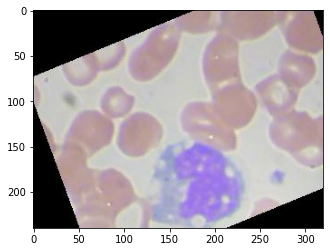

In [20]:
path = "images/TEST/MONOCYTE/_0_1123.jpeg"
img = cv2.imread(path)
# cv2.imshow("Monocyte",img)
# plt.plot(img)
# plt.imshow(img)
# plt.show()
# cv2.imshow("Krwinka", img)
# cv2.waitKey(0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
plt.imshow(img)
plt.show()

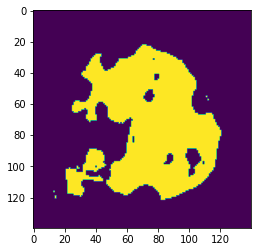

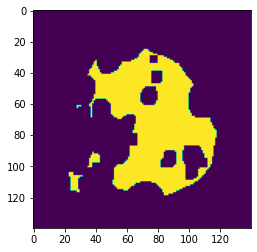

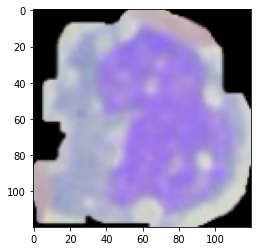

In [21]:
img = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
#thresholding the image to get the target cell
image1 = cv2.inRange(img,(80, 80, 180),(180, 170, 245))
plt.imshow(image1)
plt.show()

# openning errosion then dilation
kernel = np.ones((3, 3), np.uint8)
kernel1 = np.ones((5, 5), np.uint8)
img_erosion = cv2.erode(image1, kernel, iterations=2)

plt.imshow(img_erosion)
plt.show()
image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
gray = cv2.GaussianBlur(image1, (1, 1), 0)
edged = cv2.Canny(gray, 100, 400)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=lambda x: cv2.contourArea(x))

def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

edgedBoxes =  getBoxes(contours, img.copy())
if len(edgedBoxes)==0:
    count +=1
# get the large box and get its cordinate
last = edgedBoxes[-1]
max_x = int(max(last[:,0]))
min_x = int( min(last[:,0]))
max_y = int(max(last[:,1]))
min_y = int(min(last[:,1]))

# draw the contour and fill it 
mask = np.zeros_like(img)
cv2.drawContours(mask, contours, len(contours)-1, (255,255,255), -1) 

# any pixel but the pixels inside the contour is zero
img[mask==0] = 0

# extract th blood cell
image = img[min_y:max_y, min_x:max_x]

if (np.size(image)==0):
    count +=1
# resize th image
image = cv2.resize(image, (120,120))

plt.imshow(image)
plt.show()

(140, 140, 3)


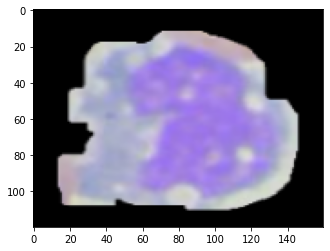

(120, 160, 3)
(57600,)


In [22]:
print(img.shape)
new_size_img = cv2.resize(img, (160, 120))
plt.imshow(new_size_img)
plt.show()
print(new_size_img.shape)
flat_img = new_size_img.flatten()
print(flat_img.shape)

In [1]:
path_test = "images/TRAIN"

def preprocess_data(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.copyMakeBorder(image, 5, 5, 5, 5,borderType=cv2.BORDER_CONSTANT,value=[199, 199, 197])
  image1 = cv2.inRange(image, (70, 60, 180), (185, 240, 245))

  kernel = np.ones((2, 2), np.uint8)
  kernel_dilate = np.ones((5,5), np.uint8)

  # image_open = cv2.morphologyEx(image1, cv2.MORPH_OPEN, kernel, iterations=4)
  image_erode = cv2.erode(image1, kernel, iterations=3)
  image_dilate = cv2.dilate(image_erode, kernel_dilate, iterations=5)
  image_Canny = cv2.Canny(image_dilate, 100, 400)

  edged = cv2.dilate(image_Canny, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)


  contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  contours = sorted(contours, key=lambda x: cv2.contourArea(x))

  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  mask = np.zeros_like(gray)

  cv2.drawContours(mask, contours, len(contours)-1, (255,255,255), thickness=cv2.FILLED)
  result = cv2.bitwise_and(image, image, mask=mask)

  result_to_cut = result.copy()

  result_to_cut = cv2.cvtColor(result_to_cut, cv2.COLOR_RGB2GRAY)

  test = np.unravel_index(result_to_cut.argmax(), result_to_cut.shape)
  im_row, im_col = np.nonzero(result_to_cut)
  new_img = image[min(im_row):max(im_row), min(im_col):max(im_col)]
  new_img = cv2.resize(new_img, (80,80))

  return new_img




def data(typ):
  path_test = "/content/drive/MyDrive/Praca inz/TRAIN"

  Cell_categories = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
  ml_cell_array = []
  dl_cell_array = []
  label_array = []
  path_dataset = ["images/TRAIN", "images/TEST"]
  label = ""
  for pd in path_dataset:
    if pd == path_dataset[0]:
      label = "TRAIN"
    else:
      label = "TEST"
    for c in Cell_categories:
      path_category = os.path.join(pd, c)
      print(f"Loading Cell Category {label}: {c}")
      i = 0
      for cell in os.listdir(path_category):
        cell_read = cv2.imread(os.path.join(path_category, cell))
        final_cell = preprocess_data(cell_read)
        dl_cell_array.append(final_cell)
        ml_img = cv2.cvtColor(final_cell, cv2.COLOR_RGB2GRAY)
        ml_cell_array.append(ml_img)
        label_array.append(Cell_categories.index(c))

      print("100% cell category loaded {0}".format(c))

  if typ == "ML":
    return ml_cell_array, label_array
  else:
    return dl_cell_array, label_array


def test_data(typ):
  path_test = "/content/drive/MyDrive/Praca inz/TEST"

  Cell_categories = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
  ml_cell_array = []
  dl_cell_array = []
  label_array = []



  for c in Cell_categories:
    path_category = os.path.join(path_test, c)
    print(f"Loading Cell Category: {c}")
    i = 0
    for cell in os.listdir(path_category):
      cell_read = cv2.imread(os.path.join(path_category, cell))
      final_cell = preprocess_data(cell_read)
      dl_cell_array.append(final_cell)
      ml_img = cv2.cvtColor(final_cell, cv2.COLOR_RGB2GRAY)
      ml_cell_array.append(ml_img)
      label_array.append(Cell_categories.index(c))

    print("100% cell category loaded {0}".format(c))

  if typ == "ML":
    return ml_cell_array, label_array
  else:
    return dl_cell_array, label_array

In [3]:
X_data, Y_data = data("ML")

Loading Cell Category TRAIN: EOSINOPHIL
100% cell category loaded EOSINOPHIL
Loading Cell Category TRAIN: LYMPHOCYTE
100% cell category loaded LYMPHOCYTE
Loading Cell Category TRAIN: MONOCYTE
100% cell category loaded MONOCYTE
Loading Cell Category TRAIN: NEUTROPHIL
100% cell category loaded NEUTROPHIL
Loading Cell Category TEST: EOSINOPHIL
100% cell category loaded EOSINOPHIL
Loading Cell Category TEST: LYMPHOCYTE
100% cell category loaded LYMPHOCYTE
Loading Cell Category TEST: MONOCYTE
100% cell category loaded MONOCYTE
Loading Cell Category TEST: NEUTROPHIL
100% cell category loaded NEUTROPHIL


In [146]:
X_data = np.array(X_data)
Y_data = np.array(Y_data)
X_data, Y_data = shuffle(X_data, Y_data, random_state=10)

In [147]:
x = X_data
x = x.reshape(len(x), -1)
print(x.max())
print(x.min())
y = Y_data
x = x/255
print(x.shape)

255
0
(12444, 19200)


In [148]:
svm_m = SVC(decision_function_shape='ovo', C=1, kernel='rbf')

In [149]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [150]:
svm_m.fit(X_train, y_train)
# print(model.best_params_)
pred_cell = svm_m.predict(X_test)
print(accuracy_score(y_test, pred_cell))

In [23]:
print(X_train.shape)
print(X_test.shape)

(9955, 6400)
(2489, 6400)


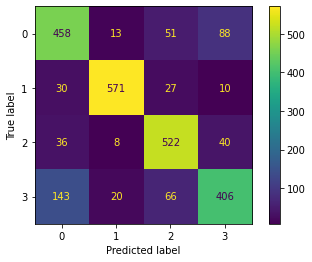

In [24]:
cm = confusion_matrix(y_test, pred_cell)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_m.classes_)
disp.plot()
plt.show()

In [25]:
report = classification_report(y_test, pred_cell)
print(f'Classification Report:\n{report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       610
           1       0.93      0.89      0.91       638
           2       0.78      0.86      0.82       606
           3       0.75      0.64      0.69       635

    accuracy                           0.79      2489
   macro avg       0.79      0.79      0.79      2489
weighted avg       0.79      0.79      0.79      2489



In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_c = RandomForestClassifier(n_estimators=100)
rf_c = rf_c.fit(X_train, y_train)

pred_forest = rf_c.predict(X_test)
print(accuracy_score(y_test, pred_forest))

0.8638007231820009


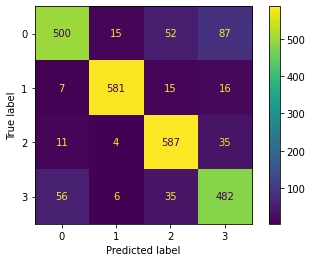

In [19]:
cm = confusion_matrix(y_test, pred_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_c.classes_)
disp.plot()
plt.show()

CNN

In [26]:
X_data, Y_data = data("DL")

Loading Cell Category TRAIN: EOSINOPHIL
100% cell category loaded EOSINOPHIL
Loading Cell Category TRAIN: LYMPHOCYTE
100% cell category loaded LYMPHOCYTE
Loading Cell Category TRAIN: MONOCYTE
100% cell category loaded MONOCYTE
Loading Cell Category TRAIN: NEUTROPHIL
100% cell category loaded NEUTROPHIL
Loading Cell Category TEST: EOSINOPHIL
100% cell category loaded EOSINOPHIL
Loading Cell Category TEST: LYMPHOCYTE
100% cell category loaded LYMPHOCYTE
Loading Cell Category TEST: MONOCYTE
100% cell category loaded MONOCYTE
Loading Cell Category TEST: NEUTROPHIL
100% cell category loaded NEUTROPHIL


In [27]:
X_data = np.array(X_data)
Y_data = np.array(Y_data)
X_data, Y_data = shuffle(X_data, Y_data, random_state=10)

In [28]:
x = X_data
x = x/255.
y = Y_data
print(x.shape)

(12444, 80, 80, 3)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(9955, 80, 80, 3)
(1244, 80, 80, 3)
(1245, 80, 80, 3)


In [136]:
model_conv = keras.Sequential()


model_conv.add(keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(80, 80, 3)))

model_conv.add(keras.layers.MaxPooling2D((2,2)))

model_conv.add(keras.layers.Conv2D(64, (2,2), activation='relu'))

model_conv.add(keras.layers.MaxPooling2D((2,2)))

model_conv.add(keras.layers.Conv2D(64, (2,2), activation='relu'))

model_conv.add(keras.layers.MaxPooling2D((2,2)))
model_conv.add(keras.layers.Dropout(0.4))

model_conv.add(keras.layers.Flatten())

model_conv.add(keras.layers.Dense(256, activation='relu'))

model_conv.add(keras.layers.Dense(64, activation='relu'))

model_conv.add(keras.layers.Dense(16, activation='relu'))

model_conv.add(keras.layers.Dense(4, activation='softmax'))

model_conv.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 79, 79, 32)        416       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 38, 38, 64)        8256      
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 18, 18, 64)        16448     
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 9, 9, 64)        

In [137]:
model_conv.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [138]:
model_fit = model_conv.fit(X_train,
                    y_train,
                    epochs = 30,
                    validation_data = (X_val, y_val))

Epoch 1/30
312/312 [==============================] - 52s 162ms/step - loss: 1.1528 - accuracy: 0.4276 - val_loss: 1.0331 - val_accuracy: 0.4900
Epoch 2/30
312/312 [==============================] - 49s 158ms/step - loss: 0.8872 - accuracy: 0.5828 - val_loss: 1.0604 - val_accuracy: 0.5068
Epoch 3/30
312/312 [==============================] - 48s 155ms/step - loss: 0.6490 - accuracy: 0.7048 - val_loss: 0.5785 - val_accuracy: 0.7309
Epoch 4/30
312/312 [==============================] - 50s 162ms/step - loss: 0.5073 - accuracy: 0.7712 - val_loss: 0.4674 - val_accuracy: 0.7855
Epoch 5/30
312/312 [==============================] - 51s 163ms/step - loss: 0.4388 - accuracy: 0.8013 - val_loss: 0.4244 - val_accuracy: 0.7880
Epoch 6/30
312/312 [==============================] - 53s 169ms/step - loss: 0.4009 - accuracy: 0.8205 - val_loss: 0.4021 - val_accuracy: 0.8225
Epoch 7/30
312/312 [==============================] - 53s 169ms/step - loss: 0.3584 - accuracy: 0.8410 - val_loss: 0.5342 - val_ac

Predykcja

In [139]:
cnn_pred = model_conv.predict(X_test)

In [140]:
print(cnn_pred)
y_pred_classes = np.argmax(cnn_pred, axis=1)

[[9.9998724e-01 7.1638556e-11 1.8561870e-09 1.2752340e-05]
 [4.9032714e-08 1.5077498e-14 8.9353258e-10 1.0000000e+00]
 [2.4277490e-12 1.3068548e-16 4.1914170e-11 1.0000000e+00]
 ...
 [3.4749348e-04 4.7358818e-04 2.6418935e-04 9.9891472e-01]
 [1.4102589e-07 1.7202727e-07 9.9999917e-01 5.4270885e-07]
 [2.3738578e-09 1.7406656e-08 9.9999988e-01 6.9270634e-08]]


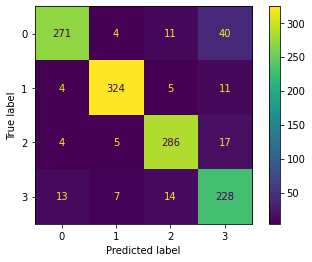

In [141]:
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_c.classes_)
disp.plot()
plt.show()

In [142]:
score = model_conv.evaluate(X_test, y_test)

39/39 [==============================] - 1s 35ms/step - loss: 0.3018 - accuracy: 0.8915
